# 1. SETTINGS

In [ ]:
!pip install lightgbm
!pip install imblearn

  Obtaining dependency information for imblearn from https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl.metadata


In [ ]:
# libraries
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier

In [ ]:
# garbage collection
import gc
gc.enable()

In [ ]:
# pandas options
pd.set_option("display.max_columns", None)

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# random settings
seed = 42

# 2. PREPARATIONS

In [ ]:
# dataset
data = "v1"

In [ ]:
# import data
"""
train = pd.read_csv("../data/prepared/train_" + str(data) + ".csv")
test  = pd.read_csv("../data/prepared/test_"  + str(data) + ".csv")
y     = pd.read_csv("../data/prepared/y_"     + str(data) + ".csv")
"""

train = pd.read_csv("../data/prepared/train_full_cor.csv")
test  = pd.read_csv("../data/prepared/test_full_cor.csv")
y     = pd.read_csv("../data/prepared/y_full_cor.csv")

In [ ]:
# sort data
train = train.sort_values("SK_ID_CURR")
y     = y.sort_values("SK_ID_CURR")

In [ ]:
# extract target
y = y["TARGET"]

In [ ]:
# exclude features
excluded_feats = ["SK_ID_CURR"]
features = [f for f in train.columns if f not in excluded_feats]

In [ ]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 1808)
(48744, 1808)


In [ ]:
### PARAMETERS

# parallel settings
cores = 10

# learner settings
metric   = "auc"
verbose  = 500
stopping = 300

# CV settings
num_folds = 5
shuffle   = True

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)

# 3. CROSS-VALIDATION

## 3.1. ALL FEATURES

In [ ]:
# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

# placeholders
valid_aucs_cv = np.zeros(num_folds)
test_preds_cv = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()

In [ ]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):

    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]

    # train lightGBM

    gbm = gbm.fit(trn_x, trn_y,
                  eval_set = [(trn_x, trn_y), (val_x, val_y)],
                  eval_metric = metric,
                  verbose = verbose,
                  early_stopping_rounds = stopping)


    # save number of iterations
    num_iter_cv = gbm.best_iteration_

    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits

    # importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["Importance"] = gbm.feature_importances_
    fold_importance_df["Fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)

    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")

    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()

# print overall performance
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % np.mean(valid_aucs_cv))

Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.812194	training's binary_logloss: 0.231919	valid_1's auc: 0.768798	valid_1's binary_logloss: 0.244018
[1000]	training's auc: 0.844236	training's binary_logloss: 0.217848	valid_1's auc: 0.779949	valid_1's binary_logloss: 0.239509
[1500]	training's auc: 0.864408	training's binary_logloss: 0.208717	valid_1's auc: 0.7841	valid_1's binary_logloss: 0.237976
[2000]	training's auc: 0.879614	training's binary_logloss: 0.201521	valid_1's auc: 0.785876	valid_1's binary_logloss: 0.237317
[2500]	training's auc: 0.891754	training's binary_logloss: 0.195519	valid_1's auc: 0.786857	valid_1's binary_logloss: 0.236978
[3000]	training's auc: 0.901933	training's binary_logloss: 0.190292	valid_1's auc: 0.787615	valid_1's binary_logloss: 0.236723
[3500]	training's auc: 0.911506	training's binary_logloss: 0.185231	valid_1's auc: 0.788068	valid_1's binary_logloss: 0.23656
[4000]	training's auc: 0.920138	training's binary_lo

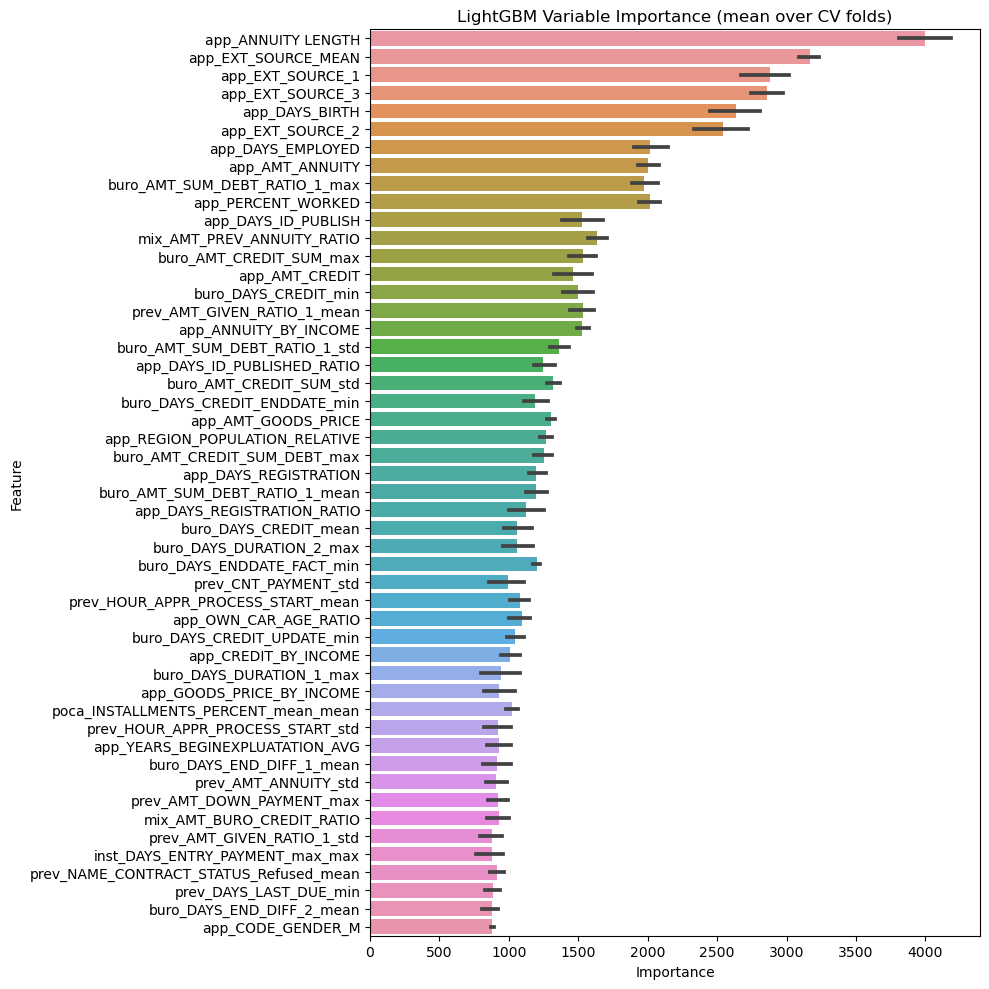

In [ ]:
##### VARIABLE IMPORTANCE

# load importance
top_feats = 50
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top_feats].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "Importance", y = "Feature", data = importance.sort_values(by = "Importance", ascending = False))
plt.title('LightGBM Variable Importance (mean over CV folds)')
plt.tight_layout()

# save plot as pdf
plt.savefig("../var_importance.pdf")

## 3.2. TOP FEATURES

In [ ]:
# keep top features
top = 500
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
features = list(importance.groupby("Feature").Importance.mean().sort_values(ascending = False).index)

In [ ]:
# check dimensions
print(train[features].shape)
print(test[features].shape)

(307511, 500)
(48744, 500)


In [ ]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):

    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]

    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y,
                  eval_set = [(trn_x, trn_y), (val_x, val_y)],
                  eval_metric = metric,
                  verbose = verbose,
                  early_stopping_rounds = stopping)

    # save number of iterations
    num_iter_cv = gbm.best_iteration_

    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits

    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")

    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()

# print overall performance
auc = np.mean(valid_aucs_cv)
print("Cross-Validation AUC score %.6f" % auc)

Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.811622	training's binary_logloss: 0.232153	valid_1's auc: 0.768851	valid_1's binary_logloss: 0.24399
[1000]	training's auc: 0.843301	training's binary_logloss: 0.218251	valid_1's auc: 0.779932	valid_1's binary_logloss: 0.239482
[1500]	training's auc: 0.863818	training's binary_logloss: 0.20901	valid_1's auc: 0.784034	valid_1's binary_logloss: 0.237983
[2000]	training's auc: 0.880134	training's binary_logloss: 0.201367	valid_1's auc: 0.786041	valid_1's binary_logloss: 0.237252
[2500]	training's auc: 0.893994	training's binary_logloss: 0.19469	valid_1's auc: 0.787172	valid_1's binary_logloss: 0.236872
[3000]	training's auc: 0.906269	training's binary_logloss: 0.188505	valid_1's auc: 0.787754	valid_1's binary_logloss: 0.236677
[3500]	training's auc: 0.917135	training's binary_logloss: 0.18264	valid_1's auc: 0.788043	valid_1's binary_logloss: 0.2366
[4000]	training's auc: 0.926281	training's binary_loglo

# 4. SUBMISSION

In [ ]:
# create submission
test["TARGET"] = test_preds_cv
subm = test[["SK_ID_CURR", "TARGET"]]

In [ ]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
best = pd.read_csv("../submissions/rmean_top10.csv")
spearmanr(test.TARGET, best.TARGET)

SignificanceResult(statistic=0.9788130406776158, pvalue=0.0)

In [ ]:
# export CSV
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_bag_lgb_top" + str(top) + ".csv", index = False, float_format = "%.8f")

In [ ]:
# no card, old features (560):            0.786941 | 0.783
# no card, new features (694):            0.788893 | 0.783
# with card, new features (1072):         0.790123 | 0.787
# with card and kernel features (1109):   0.790053 |
# card, kernel, factorize, no na (978):   0.790803 |
# card, kern, fac, nona, adummy (1193):   0.791321 |
# full data, one-hot ecoding (1844):      0.791850 |
# full data, one-hot, extra sums (2486):  0.791880 | 0.789
# full, one-hot, sums, buroscore (2501):  0.791761 |
# full, one-hot, clean, buroscore (1826): 0.791867 |
# last data + ext, age ratios (1828):     0.791808 |
# new app feats, remove weighted (1830):  0.794241 | 0.795
# previous data - top1000 LGB features:   0.794384 |
# select top1500 LGB features:            0.794384 |